*Name:* Jorge Eduardo Angarita Pérez

*Student Code:* 2248431

"_By Pedal_" implmentation of an ARX model for the Dryer2 model example for Matlab

First, some libraries are imported.

In [1]:
import numpy as np                          # General numerical data processing
import matplotlib.pyplot as plt             # Plots
import pandas as pd                         # CSV data management

### *Previous steps:*

Import dryer2 data

In [2]:
CSV_dryer2 = 'dryer2.csv'
dryer2 = pd.read_csv(CSV_dryer2)
print(dryer2.keys())

Index(['Time', 'Input', 'Output'], dtype='object')


Print input and output vs time

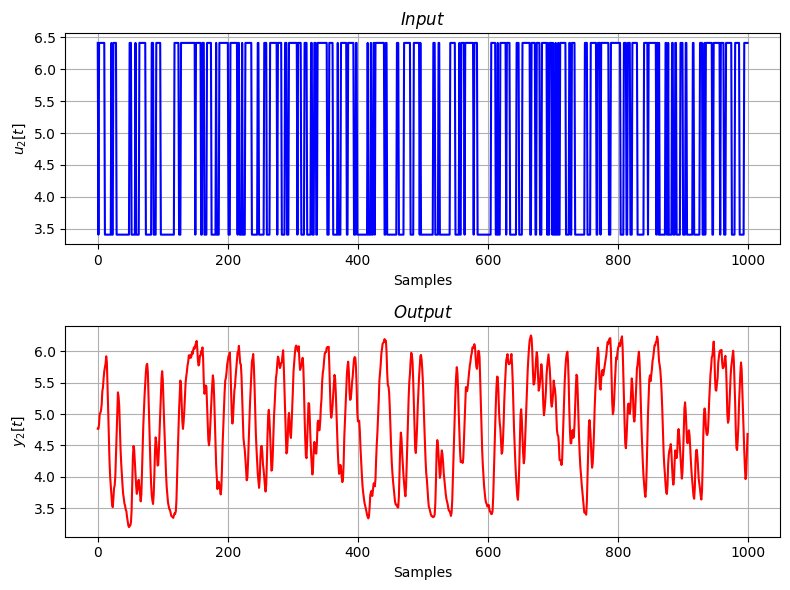

In [3]:
# Convert data-frame columns to Numpy
time = dryer2['Time'].to_numpy()
input = dryer2['Input'].to_numpy()
output = dryer2['Output'].to_numpy()

# Total Time
t_tot = len(input)

#  Top Figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Input
axs[0].plot(time, input, color='b')
axs[0].set_title('$Input$')
axs[0].set_xlabel('Samples') 
axs[0].set_ylabel('$u_2[t]$') 
axs[0].grid(True)

# Output
axs[1].plot(time, output, color='r')
axs[1].set_title('$Output$')
axs[1].set_xlabel('Samples') 
axs[1].set_ylabel('$y_2[t]$') 
axs[1].grid(True)

plt.tight_layout()
plt.show()


Create a function to evaluate the model based in the differences equation:

In [4]:
def Model_Eval(theta, na, nb, u, y):
    y_pred = np.zeros_like(u, dtype = float)

    # Number of samples
    t_tot = len(u)

    y_ranges = np.zeros((t_tot, na))
    u_ranges = np.zeros((t_tot, nb))

    for i in range(na):
        # Shifted Outputs
        y_ranges[i + 1:, i] = -y[:-(i + 1)]
    for i in range(nb):
        # Shifted Inputs
        u_ranges[i + 1:, i] = u[:-(i + 1)] 
    
    # Define phi
    phi = np.hstack((y_ranges, u_ranges))
    y_pred = np.matmul(phi,theta)
    return y_pred


### *ARX Model estimation*

A vector of theta weights will be created:

In [5]:
na = 2
nb = 4
theta = np.random.rand(na + nb)

A cost function based on least squares is introduced:

In [6]:
# Mean square error loss
def Cost(weights, batch_index=None, u=input, y=output, A_size=na, B_size=nb):
    # Eval Model
    output_pred = Model_Eval(weights, A_size, B_size, u, y)

    # Use Batch index for MSE
    if batch_index is not None:
        output_real = y[batch_index]
        output_pred = output_pred[batch_index]
    else:
        output_real = y

    mse = np.mean((output_real - output_pred) ** 2)
    return mse

Ini_Cost = Cost(theta)
print(f'Initial Cost: {Ini_Cost}')

Initial Cost: 11.31070590571246


Additionally, to use a mini-batch, an additional function is used to generate it:

In [7]:
def Batch_Generator(Cost, batch_size=None, total_size=None, seed=42):
    if batch_size is not None:
        # Seed
        np.random.seed(seed)

        # Generate Batch Index
        batch_index = np.random.choice(total_size, size=batch_size, replace=False)
    else:
        batch_index = None
    
    # Generate a Cost function for the Batch values
    def Cost_Batch(weights):
        return Cost(weights, batch_index)
    return Cost_Batch

### *Optimization functions*

To obtain the final model parameters, four different algorithms are introduced, they are Leven Marquardt, SGD, AdaGrad, RMSProb and Adam. Some of the required functions are listed below, followed by the algorithm definitions.

In [8]:
# Multiple-Variable Functions

def Partial_deriv(f, x, index, delta):
    # Derivative usign forward difference equation
    x_delta = x.copy()

    # Increase/Decrease in the required coordinate
    x_delta[index] += delta
    return (f(x_delta) - f(x)) / delta

def Partial_2nd_Deriv(f, x, index, delta):
    x_delta_a  = x.copy()
    x_delta_b  = x.copy()
    x_delta_ab = x.copy()

    # Increase/Decrease in the required coordinate
    x_delta_a[index[0]]  += delta
    x_delta_b[index[1]]  += delta
    x_delta_ab[index[0]] += delta
    x_delta_ab[index[1]] += delta

    return (f(x_delta_ab) - f(x_delta_b) - f(x_delta_a) + f(x)) / (delta ** 2)

def Gradient(f, x, delta):
    grad = x.copy()
    for i in range(len(x)):
        grad[i] = Partial_deriv(f, x, i, delta)
    return grad

def Hessian(f, x, delta):
    n = len(x)
    Hessian = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            Hessian[i,j] = Partial_2nd_Deriv(f, x, [i,j], delta)
    return Hessian

def B_generation(H_xi, ek0):
    n = H_xi.shape[0]
    ek = ek0
    Continue = True
    while Continue:
        B_Inv = ek*np.eye(n) + H_xi
        try:
            B = np.linalg.inv(B_Inv)
            Continue = False
        except:
            ek = ek*4
    return B, ek

def Rk_generation(f, x, x_next, grad_x, H_x):
    q_x = f(x)
    q_x_next = q_x + np.dot(grad_x, (x_next - x)) + 1/2 * np.dot((x_next - x), np.dot(H_x, (x_next - x)))
    f_x_next = f(x_next)
    Rk = (f_x_next - q_x)/(q_x_next - q_x)
    return Rk

#### **Levenberg - Marquardt**

In [9]:
def Lev_Mar(f, x_ini, delta_deriv, epsilon_stop, ek0, batch_size=None, max_iters=1E+04):
    # Initial values
    x = np.array(x_ini, dtype=float)
    ek = ek0

    # Number of iterations
    k = 0
    
    # History of each iterations
    history = [x.copy()]

    print('\n >> Leven-Marquardt Method <<')
    while True:
        # Increase iterations counter
        k += 1

        # Generate Batch
        f_batch = Batch_Generator(f, batch_size, t_tot, k)

        # Gradient at current point
        grad_x = Gradient(f_batch, x, delta_deriv)

        # Hessian Matrix
        H_x = Hessian(f_batch, x, delta_deriv)
        
        # B matrix
        B, ek = B_generation(H_x, ek)
        
        # Update next "x" value
        x_next = x - np.dot(B, grad_x)
        
        # Rk Generation
        Rk = Rk_generation(f_batch, x, x_next, grad_x, H_x)
        if(Rk < 0.25):
            ek = 4*ek
        elif(Rk > 0.75):
            ek = ek/2

        # Save each update
        history.append(x_next.copy())

        # Stop criteria
        if(np.linalg.norm(grad_x) < epsilon_stop or k >= max_iters):
            break

        # Update x value
        x = x_next
    print(f'Final Value = {x_next} \nIterations = {k}')

    return x_next, history

#### **Stochastic Gradient Descent (SGD)**

In [26]:
def SGD_Opt(f, x_ini, delta_deriv, epsilon_stop, l_rate=0.001, batch_size=None, max_iters=1E+04):
    # Initial values
    x = np.array(x_ini, dtype=float)

    # Number of iterations
    k = 0
    
    # History of each iterations
    history = [x.copy()]
    
    print('\n >> Gradient Descend w/o line search <<')
    while True:
        # Increase iterations counter
        k += 1

        # Generate Batch
        f_batch = Batch_Generator(f, batch_size, t_tot, k)

        # Direction is given by the reflected gradient
        grad_x = Gradient(f_batch, x, delta_deriv)

        # Calculate the step (delta_x)
        delta_x = - grad_x * l_rate 

        # Update next "x" value
        x_next = x + delta_x

        # Save each update
        history.append(x_next.copy())
        
        # Stop criteria
        if(np.linalg.norm(grad_x) < epsilon_stop or k >= max_iters):
            print(f'STOP: Gradient Norm = {np.linalg.norm(grad_x)}')
            break

        # Update x value
        x = x_next
        
    print(f'Final Value = {x_next} \nIterations = {k}')
    return x_next, history

#### **ADAptative GRAdient (AdaGrad)**

In [25]:
def AdaGrad(f, x_ini, delta_deriv, epsilon_stop, l_rate=0.001, batch_size=None, max_iters=1E+04):
    # Initial values
    x = np.array(x_ini, dtype=float)

    # Number of iterations
    k = 0
    
    # History of each iteration
    history = [x.copy()]
    
    # Squared Accumulated Gradient (r)
    r = np.zeros_like(x)

    print('\n >> AdaGrad Optimization <<')
    while True:
        # Increase iterations counter
        k += 1

        # Generate Batch
        f_batch = Batch_Generator(f, batch_size, t_tot, k)
        
        # Calculate the gradient at the current point
        grad_x = Gradient(f_batch, x, delta_deriv)

        # Update the accumulated gradient (r)
        r += grad_x**2

        # Calculate the adaptive step (delta_x)
        delta_x = - grad_x * l_rate / (np.sqrt(r) + delta_deriv)

        # Update x to the next value
        x_next = x + delta_x

        # Save each update in history
        history.append(x_next.copy())

        # Stop criteria
        if (np.linalg.norm(grad_x) < epsilon_stop or k >= max_iters):
            print(f'STOP: Gradient Norm = {np.linalg.norm(grad_x)}')
            break

        # Update x value
        x = x_next

    print(f'Final Value = {x_next} \nIterations = {k}')
    return x_next, history

#### **RMSProb**

In [11]:
def RMSProb(f, x_ini, delta_deriv, epsilon_stop, l_rate=0.001, batch_size=None, 
            decay_rate=0.9, max_iters=1E+04):
    # Initial values
    x = np.array(x_ini, dtype=float)

    # Number of iterations
    k = 0
    
    # History of each iteration
    history = [x.copy()]
    
    # Squared Accumulated Gradient (r)
    r = np.zeros_like(x)

    print('\n >> RMSProb Optimization <<')
    while True:
        # Increase iterations counter
        k += 1

        # Generate Batch
        f_batch = Batch_Generator(f, batch_size, t_tot, k)

        # Calculate the gradient at the current point
        grad_x = Gradient(f_batch, x, delta_deriv)
        
        # Update the accumulated gradient (r)
        r = decay_rate * r + (1 - decay_rate) * grad_x**2

        # Calculate the adaptive step (delta_x)
        delta_x = - grad_x * l_rate / np.sqrt(r + 10E-8)

        # Update x to the next value
        x_next = x + delta_x

        # Save each update in history
        history.append(x_next.copy())
       
        # Stop criteria
        if (np.linalg.norm(grad_x) < epsilon_stop or k >= max_iters):
            print(f'STOP: Gradient Norm = {np.linalg.norm(grad_x)}')
            break

        # Update x value
        x = x_next

    print(f'Final Value = {x_next} \nIterations = {k}')
    return x_next, history


#### **Adam**

In [12]:
def AdamOpt(f, x_ini, delta_deriv, epsilon_stop, l_rate=0.001, batch_size=None, 
            decay_rate1=0.9, decay_rate2=0.999, max_iters=1E+04):
    # Initial values
    x = np.array(x_ini, dtype=float)

    # Number of iterations
    k = 0
    
    # History of each iteration
    history = [x.copy()]
    
    # Moment estimates initialization
    s = np.zeros_like(x)
    r = np.zeros_like(x)

    print('\n >> Adam Optimization << ')
    while True:
        # Increase iterations counter
        k += 1

        # Generate Batch
        f_batch = Batch_Generator(f, batch_size, t_tot, k)

        # Calculate the gradient at the current point
        grad_x = Gradient(f_batch, x, delta_deriv)

        # Update the first moment estimate
        s = decay_rate1 * s + (1 - decay_rate1) * grad_x
        s_hat = s/(1-decay_rate1**k)

        # Update the second moment estimate
        r = decay_rate2 * r + (1 - decay_rate2) * grad_x**2
        r_hat = r/(1-decay_rate2**k)

        # Update x to the next value
        delta_x = -l_rate * s_hat/(np.sqrt(r_hat) + 1E-08)
        x_next = x + delta_x

        # Save each update in history
        history.append(x_next.copy())
       
        # Stop criteria
        if (np.linalg.norm(grad_x) < epsilon_stop or k >= max_iters):
            print(f'STOP: Gradient Norm = {np.linalg.norm(grad_x)}')
            break

        # Update x value
        x = x_next

    print(f'Final Value = {x_next} \nIterations = {k}')
    return x_next, history

### *Testing*

Iterations are performed to obtain a better modelling:

In [37]:
epsilon = 1E-1
delta = 1E-3
ek0 = 1

# Algorithm evaluation
theta_LevMar, history_LevMar = Lev_Mar(Cost, theta, delta, epsilon, ek0)
theta_SGDOpt, history_SGDOpt = SGD_Opt(Cost, theta, delta, epsilon, 0.001, 128)
theta_AdaGra, history_AdaGra = AdaGrad(Cost, theta, delta, epsilon, 1, 128)
theta_RMSPro, history_RMSPro = RMSProb(Cost, theta, delta, epsilon, 0.01, 128)
theta_AdamOp, history_AdamOp = AdamOpt(Cost, theta, delta, epsilon, 1)


 >> Leven-Marquardt Method <<
Final Value = [-0.63633186 -0.20310721 -0.00269686 -0.00111395  0.06031973  0.10165553] 
Iterations = 4

 >> Gradient Descend w/o line search <<
STOP: Gradient Norm = 0.09906011899563853
Final Value = [-0.25007376 -0.52405299 -0.02702818  0.05050214  0.02223122  0.1758207 ] 
Iterations = 1210

 >> AdaGrad Optimization <<
STOP: Gradient Norm = 0.0805163163107593
Final Value = [-0.25489853 -0.52230566 -0.03241145  0.05238094  0.02537526  0.17179786] 
Iterations = 343

 >> RMSProb Optimization <<
STOP: Gradient Norm = 0.08119065437726077
Final Value = [-0.32923975 -0.47632237 -0.00573471  0.00479156  0.04888058  0.14078023] 
Iterations = 444

 >> Adam Optimization << 
STOP: Gradient Norm = 0.07135402800036719
Final Value = [-0.27447691 -0.52639869 -0.0047225   0.01844525  0.04017559  0.15026677] 
Iterations = 120


 > Theta < 

MATLAB = [-1.286, 0.4017, 0.0008505, 0.005366, 0.06245, 0.04432]
Python = [-0.27447691 -0.52639869 -0.0047225   0.01844525  0.04017559  0.15026677]

 > Cost Function <

INITIAL Cost: 11.31070590571246
MATLAB = 0.026614180651151165
Python = 0.05582131951057853


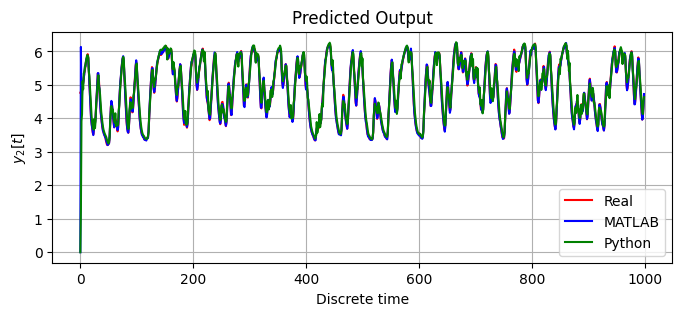

In [38]:
theta_MATLAB = [-1.286, 0.4017, 0.0008505, 0.005366, 0.06245, 0.04432]
# Choose one of the three final theta values
theta_Python = theta_AdamOp

# Print Theta values
print(' > Theta < \n')

print(f'MATLAB = {theta_MATLAB}')
print(f'Python = {theta_Python}')

# Print Final Cost Function evaluations
print('\n > Cost Function <\n')
print(f'INITIAL Cost: {Ini_Cost}')

Cost_MATLAB = Cost(theta_MATLAB)
print(f'MATLAB = {Cost_MATLAB}')

Cost_Python = Cost(theta_Python)
print(f'Python = {Cost_Python}')

#Plot Predictions
MATLAB_Pred = Model_Eval(theta_MATLAB, na, nb, input, output)
Python_Pred = Model_Eval(theta_Python, na, nb, input, output)

#Figure
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(time, output, color='r', label='Real')
ax.plot(time, MATLAB_Pred, color='b', label='MATLAB')
ax.plot(time, Python_Pred, color='g', label='Python')
ax.set_title('Predicted Output')
ax.set_xlabel('Discrete time') 
ax.set_ylabel('$y_2[t]$') 
ax.grid(True)
ax.legend()